## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## Assignment 2

## James McDermott

* Student ID(s): **Jash Prakash Rana**
* Student name(s): **22222806**

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this assignment the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [1]:
import numpy as np
import pandas as pd
import os
import math
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

np.random.seed(2023)
tf.random.set_seed(2023)

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [3]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [4]:
img_array = np.array(images)

In [5]:
img_array.shape

(1238, 268, 182, 3)

In [14]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", 
                 encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

imdbId                           Imdb Link  \
0  114709  http://www.imdb.com/title/tt114709   
1  113497  http://www.imdb.com/title/tt113497   
2  113228  http://www.imdb.com/title/tt113228   
3  114885  http://www.imdb.com/title/tt114885   
4  113041  http://www.imdb.com/title/tt113041   

                                Title  IMDB Score                       Genre  \
0                    Toy Story (1995)         8.3  Animation|Adventure|Comedy   
1                      Jumanji (1995)         6.9     Action|Adventure|Family   
2             Grumpier Old Men (1995)         6.6              Comedy|Romance   
3            Waiting to Exhale (1995)         5.7        Comedy|Drama|Romance   
4  Father of the Bride Part II (1995)         5.9       Comedy|Family|Romance   

                                              Poster    Year  
0  https://images-na.ssl-images-amazon.com/images...  1995.0  
1  https://images-na.ssl-images-amazon.com/images...  1995.0  
2  https://images-na.ssl-images-amazon.com/images...  1995.0  
3  https://images-na.ssl-images-amazon.com/images...  1995.0  
4  https://images-na.ssl-images-amazon.com/images...  1995.0

In [7]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [8]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [9]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [10]:
df4.shape # 1254 rows matches the image data shape above

(1238, 6)

In [11]:
df4

Imdb Link  \
imdbId                                         
1000771  http://www.imdb.com/title/tt1000771   
100148    http://www.imdb.com/title/tt100148   
1001540  http://www.imdb.com/title/tt1001540   
100200    http://www.imdb.com/title/tt100200   
1002563  http://www.imdb.com/title/tt1002563   
...                                      ...   
99611      http://www.imdb.com/title/tt99611   
996967    http://www.imdb.com/title/tt996967   
99726      http://www.imdb.com/title/tt99726   
99768      http://www.imdb.com/title/tt99768   
99836      http://www.imdb.com/title/tt99836   

                                     Title  IMDB Score  \
imdbId                                                   
1000771                     Recount (2008)         7.5   
100148                Midnight Ride (1990)         5.2   
1001540                 Perestroika (2009)         4.5   
100200            Mr. & Mrs. Bridge (1990)         6.7   
1002563           The Young Messiah (2016)         5.5   
...                                    ...         ...   
99611                 Frankenhooker (1990)         6.1   
996967                         Otis (2008)         6.1   
99726                        Hamlet (1990)         6.8   
99768                 Hidden Agenda (1990)         7.0   
99836    In nome del popolo sovrano (1990)         6.8   

                          Genre  \
imdbId                            
1000771           Drama|History   
100148   Action|Horror|Thriller   
1001540                   Drama   
100200                    Drama   
1002563                   Drama   
...                         ...   
99611             Comedy|Horror   
996967      Comedy|Crime|Horror   
99726                     Drama   
99768            Drama|Thriller   
99836             Drama|History   

                                                    Poster    Year  
imdbId                                                              
1000771  https://images-na.ssl-images-amazon.com/images...  2008.0  
100148   https://images-na.ssl-images-amazon.com/images...  1990.0  
1001540  https://images-na.ssl-images-amazon.com/images...  2009.0  
100200   https://images-na.ssl-images-amazon.com/images...  1990.0  
1002563  https://images-na.ssl-images-amazon.com/images...  2016.0  
...                                                    ...     ...  
99611    https://images-na.ssl-images-amazon.com/images...  1990.0  
996967   https://images-na.ssl-images-amazon.com/images...  2008.0  
99726    https://images-na.ssl-images-amazon.com/images...  1990.0  
99768    https://images-na.ssl-images-amazon.com/images...  1990.0  
99836    https://images-na.ssl-images-amazon.com/images...  1990.0  

[1238 rows x 6 columns]

In [12]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]

In [13]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [15]:
n_movies = img_array.shape[0]
embedding_size = 100352 # YOUR CODE HERE
X = tf.zeros((n_movies, embedding_size))

### YOUR CODE HERE
with tf.device("/GPU:0"):
    model = keras.models.Sequential([
        ResNet50(weights='imagenet', 
                 include_top = False, 
                 input_shape = (268, 182, 3)),
        layers.Flatten()
    ])
    x = preprocess_input(img_array)
    X = model.predict(x)
    

assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies

39/39 [==============================] - 11s 79ms/step


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 9, 6, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 110592)            0         
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [17]:
def k_nearest(img, k):
    ### YOUR CODE HERE
    if type(img) == int:
        image = f"DL_Sample/{img}.jpg"
        im = Image.open(image)
        img = np.array(im, dtype=float)
        img = tf.expand_dims(img, axis = 0)

    img = preprocess_input(img)
    pred = model.predict(img)

    distance = cdist(pred, X, metric = "hamming")
    img_index = np.argsort(distance[0])
    distance = np.sort(distance[0])
    
    neighbours = []
    for i in range(k+1):
        neighbours.append(IDs[img_index[i]])
    
    return np.array(distance[1:k+1]), np.array(neighbours[1:k+1])

In [17]:
k_nearest(90837, 2)

1/1 [==============================] - 1s 818ms/step


(array([0.23546007, 0.23999928]), array([ 106215, 1977002]))

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


1/1 [==============================] - 1s 958ms/step


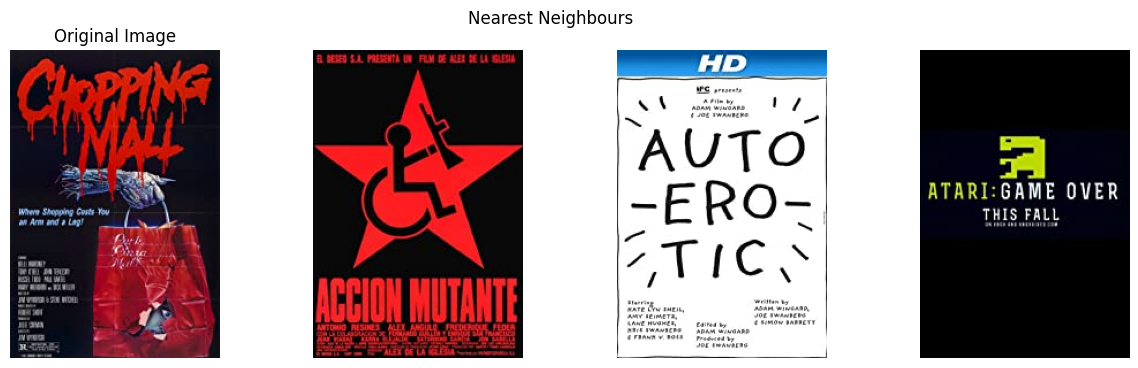

In [18]:
### YOUR CODE HERE
'''
The images are showing as per below due to the lowest distance calculated 
between them. The first image is the reference image and the other three 
are the closest. There is a similarity of color in the 2nd image seen, while 
there is not much similarity if we see the 3rd and the 4th image displayed, 
but it feels the algorithm calculated the closest distance due to less colours
used in the posters. I don't agree to an extend with the ranking given by the 
cdist algorithm as it's just calculating colour-based similarities and falls 
over to the basic colour schemes when it doesn't find similar colours from the 
given image. The embeddings may be close due to black and white being the most 
in the pixels. I guess the era plays an important role in the poster designning 
and so maybe the nearest neighbours are caught from the similar era as people 
are trying to use the similar styles more often.
'''

fig = plt.figure(figsize = (15,4))


Q_idx = 90837 # YOUR VALUE HERE - DO NOT USE MY VALUE
distances, neighbours = k_nearest(90837, 3)



for i in range(0, 4):
    if i == 0:
        plt.subplot(1,4,i+1)
        plt.imshow(imread(Q_idx))
        plt.axis('off')
        plt.title('Original Image')
        continue
    
    plt.subplot(1,4,i+1)
    plt.imshow(imread(int(neighbours[i-1])))
    plt.axis('off')

plt.suptitle('Nearest Neighbours')
plt.show()



### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [72]:
'''
We are making a new regression head with Sequential
model in which we keep 2 dense layers with `relu`
activation and the last dense layer acting as the
"linear" head
'''

regressor = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1, activation = "linear")
])

In [20]:
### YOUR CODE HERE
from sklearn.model_selection import train_test_split

y = df4.loc[IDs]
y = np.array(y["Year"])

assert X.shape[0] == y.shape[0]

# X is taken from Part 1 where the embeddings are created.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle = True, random_state = 2023)

In [80]:
'''
Taking Adam Optimizer with learning rate 0.01, 
and MeanSquaredError as Loss function as it is
a regresion task.
'''

regressor.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)
print(regressor.optimizer)
print(regressor.loss)

In [81]:
#Ref: https://www.tensorflow.org/api_docs/python/
#tf/keras/callbacks/ModelCheckpoint
'''
Model Checkpoint is the way to get the
best weights from the gradients as the
model's loss can vary, and finding the
lowest loss can mean a better regression
task. Here, validation loss is being used
to find the lowest loss and saving those
weights to use with the model. 
'''

checkpoint_filepath = './tmp/checkpoint'
best_model = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', 
    save_best_only=True, save_weights_only=True, verbose = 1)

In [23]:
with tf.device("/GPU:0"):
    history = regressor.fit(X_train, y_train, epochs = 100, 
                            batch_size = None, validation_split = 0.2, 
                            callbacks = [best_model], shuffle = False)

Epoch 1/100
24/25 [===========================>..] - ETA: 0s - loss: 1502828.0000
Epoch 1: val_loss improved from inf to 164511.90625, saving model to ./tmp\checkpoint
25/25 [==============================] - 3s 101ms/step - loss: 1465386.6250 - val_loss: 164511.9062
Epoch 2/100
24/25 [===========================>..] - ETA: 0s - loss: 152599.6562
Epoch 2: val_loss improved from 164511.90625 to 56392.25781, saving model to ./tmp\checkpoint
25/25 [==============================] - 3s 105ms/step - loss: 150925.8125 - val_loss: 56392.2578
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 92736.5938 
Epoch 3: val_loss did not improve from 56392.25781
25/25 [==============================] - 0s 20ms/step - loss: 92736.5938 - val_loss: 65140.6914
Epoch 4/100
21/25 [========================>.....] - ETA: 0s - loss: 30611.0742
Epoch 4: val_loss improved from 56392.25781 to 42580.81641, saving model to ./tmp\checkpoint
25/25 [==============================] - 2s 68ms/step - lo

In [24]:
regressor.summary()

''' 
Load weight takes the file we created using
Model Checkpoint and loads the weight it
found while the validation loss was lowest.
'''
regressor.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               56623616  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 56,628,757
Trainable params: 56,628,757
Non-trainable params: 0
_________________________________________________________________


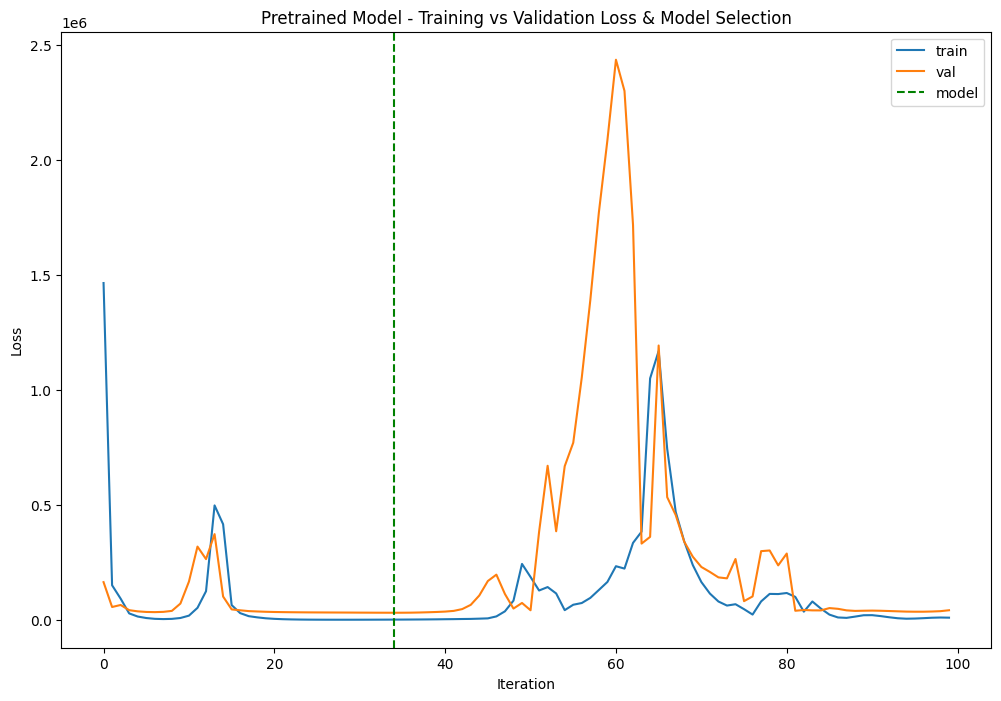

In [56]:
lowest = np.amin(history.history['val_loss'])
time = np.where(history.history['val_loss'] == lowest)


fig = plt.figure(figsize = (12,8))
fig = plt.plot(history.history['loss'])
fig = plt.plot(history.history['val_loss'])
fig = plt.axvline(x = time, color = 'green', linestyle = '--')
plt.title(
    'Pretrained Model - Training vs Validation Loss & Model Selection')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['train', 'val', 'model'], loc= 'upper right')
plt.show()

In [25]:
preds = regressor.predict(X_test)
preds = preds.flatten()
preds_round = [round(val, 0) for val in preds]

8/8 [==============================] - 0s 3ms/step


In [26]:
print(f"Mean Absolute Error: 
      {mean_absolute_error(y_test, preds_round)}\n")
print(f"Mean Squared Error: 
      {mean_squared_error(y_test, preds_round)}\n")
print(f"Root Mean Squared Error: 
      {math.sqrt(mean_squared_error(y_test, preds_round))}\n")

Mean Absolute Error: 152.7701612903226

Mean Squared Error: 37984.13306451613

Root Mean Squared Error: 194.89518481613683



In [27]:
out_df = pd.DataFrame({"Y_test" : y_test, 
                       "Predictions" : preds_round, 
                       "Difference" : y_test - preds_round}, 
                      columns = 
                      ["Y_test", "Predictions", "Difference"])
out_df

Y_test  Predictions  Difference
0    1991.0       1818.0       173.0
1    1992.0       1837.0       155.0
2    2011.0       2331.0      -320.0
3    1967.0       1823.0       144.0
4    1992.0       1733.0       259.0
..      ...          ...         ...
243  2007.0       2189.0      -182.0
244  1998.0       1899.0        99.0
245  1952.0       1798.0       154.0
246  1980.0       2089.0      -109.0
247  2014.0       2040.0       -26.0

[248 rows x 3 columns]

[]

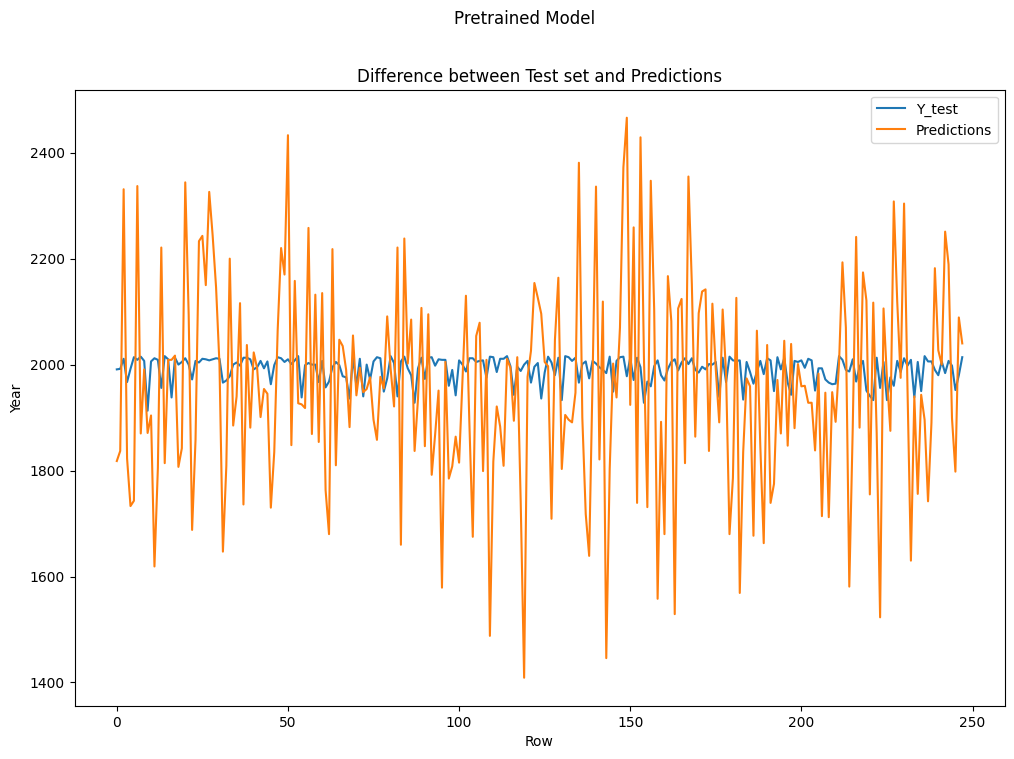

In [70]:
fig = plt.figure(figsize = (12,8))
plt.plot(out_df[['Y_test','Predictions']])
plt.legend(['Y_test', 'Predictions'], loc= 'upper right')
plt.xlabel('Row')
plt.ylabel('Year')
plt.title("Difference between Test set and Predictions")
plt.suptitle('Pretrained Model')

plt.plot()

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


---

#### 5.1 Model Implementation
Creating a model with 4 Conv2D layers and 4 Average Pooling layers, Flatten & Dropout layers, and 4 Dense layers with final dense layer as linear activation for regression task.

In [28]:
'''
Training an end-to-end convnet of your 
own design (no pretraining)
'''

new_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), padding = "same", 
                  activation = 'relu', 
                  input_shape = (268, 182, 3), 
                  name = 'Conv2D_32'),
    layers.AveragePooling2D(pool_size = (2, 2), 
                            strides = None, 
                            padding = "valid", 
                            name = 'Avg_Pool1'),
    layers.Conv2D(64, (3, 3), padding = "valid", 
                  activation = 'relu', 
                  name = 'Conv2D_64'),
    layers.AveragePooling2D(pool_size = (2, 2), 
                            strides = None, 
                            padding = "valid", 
                            name = 'Avg_Pool2'),
    layers.Conv2D(128, (5, 5), 
                  padding = "same", 
                  activation = 'relu', 
                  name = 'Conv2D_128'),
    layers.AveragePooling2D(pool_size = (2, 2), 
                            strides = None, 
                            padding = "valid", 
                            name = 'Avg_Pool3'),
    layers.Conv2D(256, (7, 7), padding = "same", 
                  activation = 'relu', 
                  name = 'Conv2D_64_2'),
    layers.AveragePooling2D(pool_size = (2, 2), 
                            strides = None, 
                            padding = "valid", 
                            name = 'Avg_Pool4'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu", 
                 name = 'dense_1'),
    layers.Dense(64, activation="relu", 
                 name = 'dense_2'),
    layers.Dense(10, activation="relu", 
                 name = 'dense_3'),
    layers.Dense(1, activation = "linear", 
                 name = 'linear_layer')
])

#### 5.2 Model Compilation
Choosing Adadelta with learning rate 0.01
Calculating loss with Mean Squared Error for Regression Tasks

In [29]:
new_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [30]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_32 (Conv2D)          (None, 268, 182, 32)      896       
                                                                 
 Avg_Pool1 (AveragePooling2D  (None, 134, 91, 32)      0         
 )                                                               
                                                                 
 Conv2D_64 (Conv2D)          (None, 132, 89, 64)       18496     
                                                                 
 Avg_Pool2 (AveragePooling2D  (None, 66, 44, 64)       0         
 )                                                               
                                                                 
 Conv2D_128 (Conv2D)         (None, 66, 44, 128)       204928    
                                                                 
 Avg_Pool3 (AveragePooling2D  (None, 33, 22, 128)     

#### 5.3 Model Checkpoint
Saving the weights of the lowest value in validation loss found during training phase.

In [31]:
new_checkpoint_filepath = './tmp/checkpoint1'
new_best = keras.callbacks.ModelCheckpoint(
    new_checkpoint_filepath, monitor='val_loss', 
    save_best_only=True, save_weights_only=True, 
    verbose = 1)

In [32]:
X_train1, X_test1, y_train1, y_test1 = 
train_test_split(img_array/255, y, test_size=0.2, 
                 shuffle = True, random_state = 2023)

In [33]:
#Ref: https://www.linkedin.com/pulse/
#solving-out-memory-oom-errors-keras-tensorflow-running-wayne-cheng/
'''
This code is taken from the above reference, and is 
used to dynamically allocate memory to GPU making it
available for each tensorflow operation. This code is
making sure the below code runs without issues.
'''

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#### 5.4 Model Training
Training the model with 100 epochs, batch size 8 and 20% data split for validation purposes.

In [34]:
with tf.device("/GPU:0"):
    new_history = new_model.fit(X_train1, y_train1, 
                                epochs = 100, batch_size = 8, 
                                validation_split = 0.2, 
                                callbacks = [new_best], 
                                shuffle = False)

Epoch 1/100
97/99 [============================>.] - ETA: 0s - loss: 1113675.8750
Epoch 1: val_loss improved from inf to 199493.71875, saving model to ./tmp\checkpoint1
99/99 [==============================] - 6s 31ms/step - loss: 1097709.2500 - val_loss: 199493.7188
Epoch 2/100
97/99 [============================>.] - ETA: 0s - loss: 115009.9141
Epoch 2: val_loss improved from 199493.71875 to 49021.37500, saving model to ./tmp\checkpoint1
99/99 [==============================] - 3s 26ms/step - loss: 113602.0469 - val_loss: 49021.3750
Epoch 3/100
97/99 [============================>.] - ETA: 0s - loss: 52829.0938
Epoch 3: val_loss improved from 49021.37500 to 27767.32031, saving model to ./tmp\checkpoint1
99/99 [==============================] - 3s 26ms/step - loss: 52240.7227 - val_loss: 27767.3203
Epoch 4/100
97/99 [============================>.] - ETA: 0s - loss: 31089.6992
Epoch 4: val_loss improved from 27767.32031 to 17154.51953, saving model to ./tmp\checkpoint1
99/99 [========

In [37]:
new_model.load_weights(new_checkpoint_filepath)

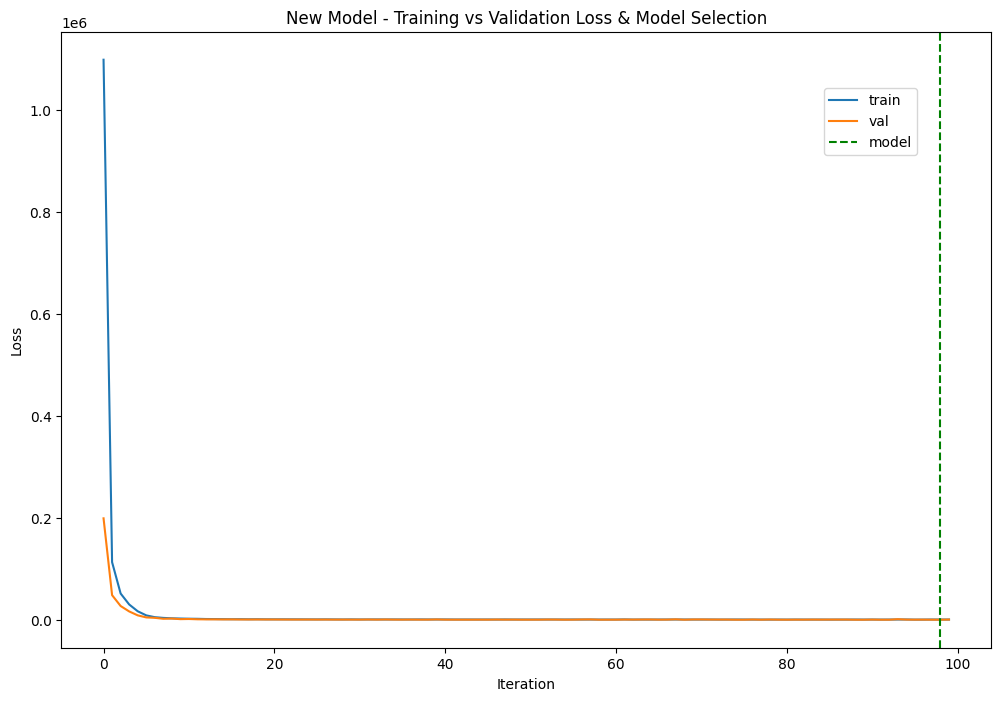

In [53]:
lowest = np.amin(new_history.history['val_loss'])
time = np.where(new_history.history['val_loss'] == lowest)


fig = plt.figure(figsize = (12,8))
fig = plt.plot(new_history.history['loss'])
fig = plt.plot(new_history.history['val_loss'])
fig = plt.axvline(x = time, color = 'green', linestyle = '--')
plt.title(
    'New Model - Training vs Validation Loss & Model Selection')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['train', 'val', 'model'], loc= (0.82, 0.8))
plt.show()

#### 5.5 Model Evaluation

In [38]:
test_loss = new_model.evaluate(X_test1, y_test1)
print(f"Test MSLE Loss: {test_loss}")

8/8 [==============================] - 1s 93ms/step - loss: 724.2055
Test MSLE Loss: 724.2055053710938


In [39]:
new_preds = new_model.predict(X_test1)
new_preds = new_preds.flatten()
new_preds_round = [round(val, 0) for val in new_preds]

8/8 [==============================] - 0s 16ms/step


In [40]:
print(f"Mean Absolute Error: 
      {mean_absolute_error(y_test, new_preds_round)}\n")
print(f"Mean Squared Error: 
      {mean_squared_error(y_test, new_preds_round)}\n")
print(f"Root Mean Squared Error: 
      {math.sqrt(mean_squared_error(y_test, new_preds_round))}\n")

Mean Absolute Error: 21.83467741935484

Mean Squared Error: 723.3991935483871

Root Mean Squared Error: 26.89608137904827



In [58]:
new_out = pd.DataFrame({"Y_test" : y_test1, 
                        "Predictions" : new_preds_round, 
                        "Difference" : y_test1 - new_preds_round}, 
                      columns = 
                       ["Y_test", "Predictions", "Difference"])
new_out.sort_values(['Y_test'])

Y_test  Predictions  Difference
9    1913.0       1976.0       -63.0
87   1928.0       1983.0       -55.0
154  1928.0       1966.0       -38.0
130  1933.0       1973.0       -40.0
221  1933.0       1974.0       -41.0
..      ...          ...         ...
211  2016.0       1991.0        25.0
80   2016.0       1986.0        30.0
114  2016.0       1909.0       107.0
236  2016.0       1987.0        29.0
53   2016.0       1980.0        36.0

[248 rows x 3 columns]

[]

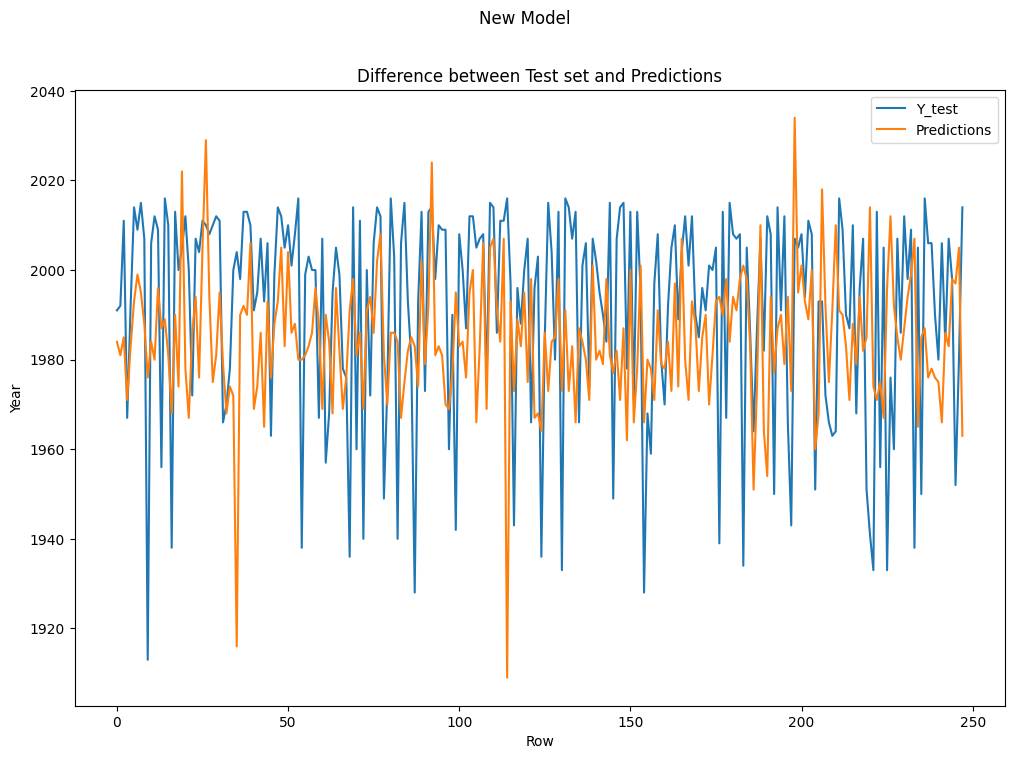

In [69]:
fig = plt.figure(figsize = (12,8))
plt.plot(new_out[['Y_test','Predictions']])
plt.legend(['Y_test', 'Predictions'], loc= 'upper right')
plt.xlabel('Row')
plt.ylabel('Year')
plt.title("Difference between Test set and Predictions")
plt.suptitle('New Model')

plt.plot()

#### 5.6 Model Comparison
A direct comparison between both the models suggest that the new trained model works well with the data, and the major reason being that this model was designed to specifically work with the `Poster` dataset. The Adadelta helped with the decaying learning rate factor which improved the training of course, but the final verdict is seen in Part 5.6 where both are compared. The Pretrained model has imagenet weights and so it doesn't fit quite well when given to do a regression task. On the other hand, our new model has effectively proven both the regression task and also resource management as it took less time to train the model.

It's usually better to use a pretrained model for Classification task as that saves a lot of time, but Regression is a task that usually takes a whole model into consideration and so requires a different weight and needs to be trained together with the convolution layers. So for Regression, it's better to train a new model rather than using a Pre-trained model.

[]

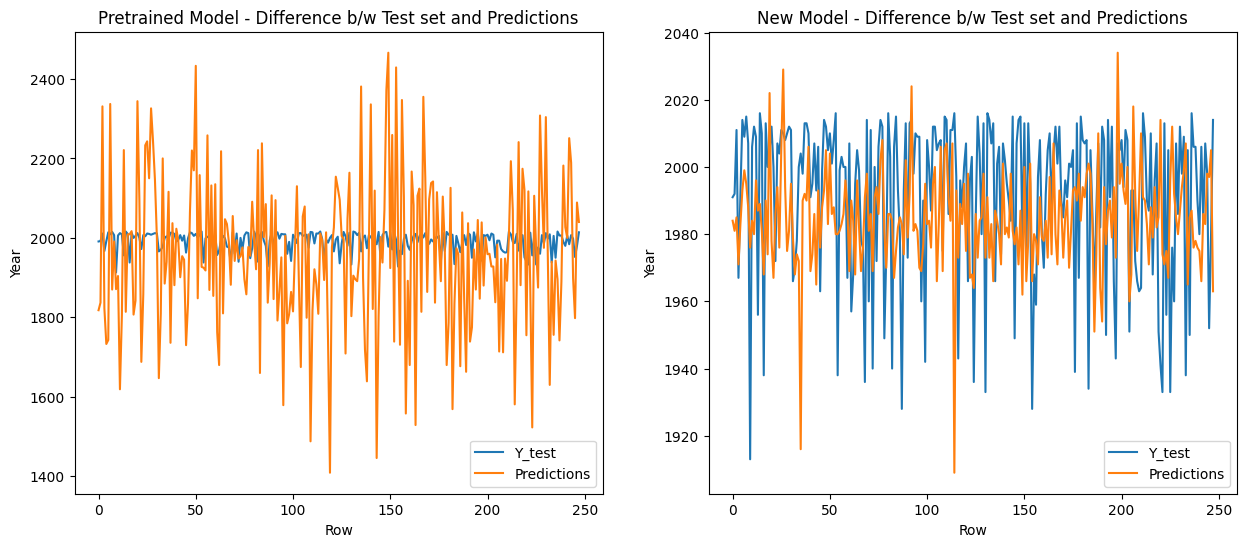

In [79]:
fig = plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
plt.plot(out_df[['Y_test','Predictions']])
plt.legend(['Y_test', 'Predictions'], loc= 'lower right')
plt.xlabel('Row')
plt.ylabel('Year')
plt.title(
    "Pretrained Model - Difference b/w Test set and Predictions")

plt.subplot(1,2,2)
plt.plot(new_out[['Y_test','Predictions']])
plt.legend(['Y_test', 'Predictions'], 
           loc= 'lower right')
plt.xlabel('Row')
plt.ylabel('Year')
plt.title(
    "New Model - Difference b/w Test set and Predictions")

plt.plot()
plt.plot()